**In this notebook you can find the code that will create a raw dataset of solar and geomagnetic parameters for the selected pulsar**

### Import the libraries and read pulsar data

In [14]:
from IPython.display import clear_output

In [15]:
!pip install pyspedas
clear_output()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
import requests

import pyspedas
from pyspedas.goes import xrs
from pytplot import get_data
from pytplot import tplot
from pyspedas.noaa import noaa_load_kp

import astropy.units as u
from tqdm import tqdm
from astropy.coordinates import EarthLocation, AltAz

from astropy.time import Time
from tqdm import tqdm

In [3]:
puls_name = "J0332" #"J0814", "J1921"

In [4]:
!gdown -O J0332_time_series.txt 1fexlMUUCyhK68NvJGqnKKuN2olbJo0F7

Downloading...
From: https://drive.google.com/uc?id=1fexlMUUCyhK68NvJGqnKKuN2olbJo0F7
To: /content/J0332_time_series.txt
100% 152k/152k [00:00<00:00, 78.8MB/s]


In [5]:
mjd_pulsar = []

with open(puls_name+"_time_series.txt", 'r') as f:
    text = f.readlines()
    for elem in text[1:]:
        s = elem.split()
        if s:
            mjd_pulsar.append(float(s[0]))

time_tmp = Time(mjd_pulsar, format = 'mjd')
time_tmp.format = 'decimalyear'
time_pulsar = np.array(time_tmp.value)

### Auroral indices

In this section we compute the dataset of auroral indices SMU, SML and SMR which has been downloaded from https://supermag.jhuapl.edu/mag/?fidelity=low&start=2018-01-29T21%3A00%3A00.000Z&interval=23%3A59&tab=largedownload for years 2014-2018 with a time resolution of 1 minute

In [2]:
!gdown -O 2014_auroral.csv 1VO8RJOaatYPalEXHTDJ-HvZfVM-X7chZ
!gdown -O 2015_auroral.csv 1q28LxSALsMOP7bfbyCVQTvmo5DdhaMQP
!gdown -O 2016_auroral.csv 1cEwIFysrgjc9bxdrWqfd62HRmtxSy4qk
!gdown -O 2017_auroral.csv 1UtLYrFpaavVRi9Dwa7bFDAF-yPhvFxkk
!gdown -O 2018_auroral.csv 1LuKnRsss7w3CoojbjVJtWTmlx7RLiQWo

Downloading...
From: https://drive.google.com/uc?id=1VO8RJOaatYPalEXHTDJ-HvZfVM-X7chZ
To: /content/2014_auroral.csv
100% 31.5M/31.5M [00:00<00:00, 61.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q28LxSALsMOP7bfbyCVQTvmo5DdhaMQP
To: /content/2015_auroral.csv
100% 31.6M/31.6M [00:00<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cEwIFysrgjc9bxdrWqfd62HRmtxSy4qk
To: /content/2016_auroral.csv
100% 31.6M/31.6M [00:00<00:00, 62.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UtLYrFpaavVRi9Dwa7bFDAF-yPhvFxkk
To: /content/2017_auroral.csv
100% 31.3M/31.3M [00:00<00:00, 73.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LuKnRsss7w3CoojbjVJtWTmlx7RLiQWo
To: /content/2018_auroral.csv
100% 31.0M/31.0M [00:00<00:00, 70.4MB/s]


Combine everything into one dataset:

In [9]:
data2014 = pd.read_csv('2014_auroral.csv')
data2015 = pd.read_csv('2015_auroral.csv')
data2016 = pd.read_csv('2016_auroral.csv')
data2017 = pd.read_csv('2017_auroral.csv')
data2018 = pd.read_csv('2018_auroral.csv')

data = pd.concat([data2014, data2015, data2016, data2017, data2018], axis=0)
data = data[['Date_UTC', 'SML', 'SMU', 'SMR']]
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

We will transfer all the times to UNIX format

In [10]:
time_tmp = Time(mjd_pulsar, format = 'mjd', scale='utc')
time_tmp.format = 'unix'
time_pulsar = time_tmp.value

time_features = list(data["Date_UTC"].astype('string'))
time_features_tmp = Time(time_features, format='iso')
time_features_tmp.format = 'unix'
time_features = time_features_tmp.value

Main function in this section which averages the values of the auroral indices over the time of observation of the pulsar

In [11]:
def get_dataset(pulsar_time, features_time, SML, SMU, SMR):

    SML_feature = []
    SMU_feature = []
    SMR_feature = []

    for i in tqdm(range(len(pulsar_time))):
        t = pulsar_time[i]
        t_start = t - 7.5*60
        t_end = t + 7.5*60

        inds = []
        for j in range(len(features_time)):
            if features_time[j] >= t_start and features_time[j] <= t_end:
                inds.append(j)

        SML_feature.append(np.mean(SML[inds]))
        SMU_feature.append(np.mean(SMU[inds]))
        SMR_feature.append(np.mean(SMR[inds]))

    dataset = pd.DataFrame({'SML': SML_feature, 'SMU' : SMU_feature, 'SMR' : SMR_feature})
    return dataset

Run the function and save the data. Calculation time: from half an hour to an hour

In [ ]:
dataset = get_dataset(time_pulsar, time_features, data['SML'].to_numpy(),\
                        data['SMU'].to_numpy(), data['SMR'].to_numpy())

In [ ]:
dataset.to_csv(puls_name+"_auroral.txt", header=None, index=None, sep=' ', mode='w')

### Other indices

In this section we compute the dataset of parameters X-ray B, SYM-H, F10.7, LST which will be download with the help of pyspedas library https://pyspedas.readthedocs.io/en/latest/noaa.html. Parameters X-ray B and F10.7 were received by NOAA GOES satellites. SYM-H indices were received by World Data Center for Geomagnetism, Kyoto. LST corresponds to local solar time which was computed for each pulsar observation. X-ray B and SYM-H parameters have a time resolution of 1 minute, F10.7 parameter has a time resolution of 2 measurements per day.

In [22]:
!gdown -O solar_fluxes.txt 1YodwkWTJTJczIRGNjNJGEvBBL9QJICQE

Downloading...
From: https://drive.google.com/uc?id=1YodwkWTJTJczIRGNjNJGEvBBL9QJICQE
To: /content/solar_fluxes.txt
100% 701k/701k [00:00<00:00, 120MB/s]


In [18]:
jd_for_flux = []
flux = []

with open("solar_fluxes.txt", 'r') as f:
    text = f.readlines()
    for elem in text:
        s = elem.split()
        if s:
            jd_for_flux.append(float(s[2]))
            flux.append(float(s[5]))

time_tmp = Time(jd_for_flux, format = 'jd')
time_tmp.format = 'decimalyear'
time_for_flux = time_tmp.value

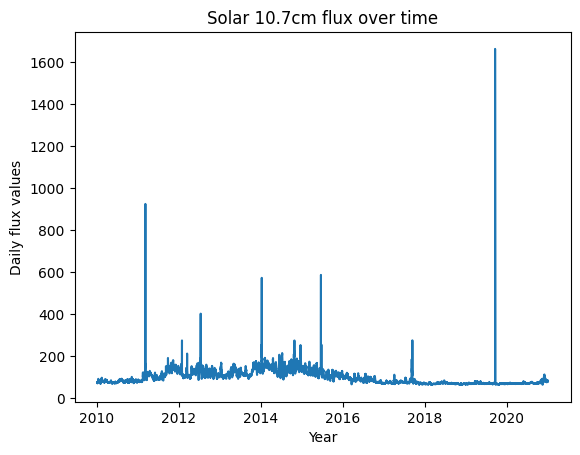

In [19]:
plt.plot(time_for_flux, flux)
plt.xlabel("Year")
plt.ylabel("Daily flux values")
plt.title("Solar 10.7cm flux over time")
plt.show()

Let's clear the fluxes data from obvious otliers:

In [20]:
time_for_flux_cleared = []
flux_cleared = []

threshold = 300
for i in range(len(flux)):
    if flux[i] < threshold:
        flux_cleared.append(flux[i])
        time_for_flux_cleared.append(time_for_flux[i])

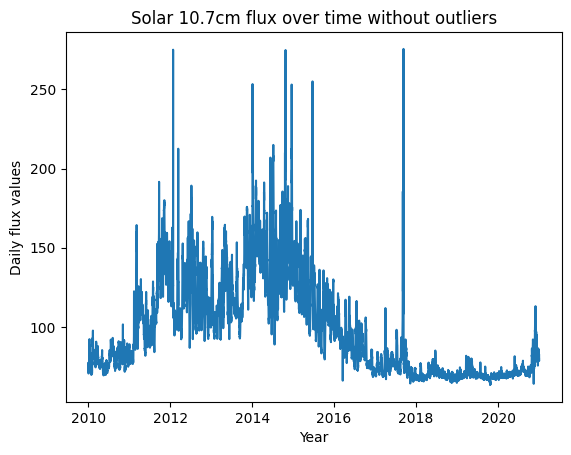

In [21]:
plt.plot(time_for_flux_cleared, flux_cleared)
plt.xlabel("Year")
plt.ylabel("Daily flux values")
plt.title("Solar 10.7cm flux over time without outliers")
plt.show()

Now we download the data for other parameters with pyspedas. It might take some time

In [29]:
import pyspedas
from pyspedas.goes import xrs
from pytplot import get_data
from pytplot import tplot

xrs_data = xrs(trange=['2014-01-01', '2018-12-31'])

time_B_AVG, B_AVG = np.array(get_data('g15_xrs_B_AVG').times), np.array(get_data('g15_xrs_B_AVG').y)
#clear_output()

26-Nov-24 21:00:35: Downloading remote index: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/2014/01/goes15/netcdf/
26-Nov-24 21:00:36: File is current: goes_data/avg/2014/01/goes15/netcdf/g15_xrs_1m_20140101_20140131.nc
26-Nov-24 21:00:36: Downloading remote index: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/2014/02/goes15/netcdf/
26-Nov-24 21:00:36: File is current: goes_data/avg/2014/02/goes15/netcdf/g15_xrs_1m_20140201_20140228.nc
26-Nov-24 21:00:36: Downloading remote index: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/2014/03/goes15/netcdf/
26-Nov-24 21:00:37: File is current: goes_data/avg/2014/03/goes15/netcdf/g15_xrs_1m_20140301_20140331.nc
26-Nov-24 21:00:37: Downloading remote index: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/2014/04/goes15/netcdf/
26-Nov-24 21:00:37: File is current: goes_data/avg/2014/04/goes15/netcdf/g15_xrs_1m_20140401_20140430.nc
26-Nov-24 21

In [30]:
omni_vars = pyspedas.omni.data(trange=['2014-01-01', '2018-12-31'])

time_SYM_H, SYM_H = np.array(get_data('SYM_H').times), np.array(get_data('SYM_H').y)
#clear_output()

26-Nov-24 21:02:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2014/
26-Nov-24 21:02:42: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2014/omni_hro2_1min_20140101_v01.cdf to omni_data/hro2_1min/2014/omni_hro2_1min_20140101_v01.cdf
26-Nov-24 21:02:42: Download complete: omni_data/hro2_1min/2014/omni_hro2_1min_20140101_v01.cdf
26-Nov-24 21:02:42: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2014/omni_hro2_1min_20140201_v01.cdf to omni_data/hro2_1min/2014/omni_hro2_1min_20140201_v01.cdf
26-Nov-24 21:02:43: Download complete: omni_data/hro2_1min/2014/omni_hro2_1min_20140201_v01.cdf
26-Nov-24 21:02:43: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2014/omni_hro2_1min_20140301_v01.cdf to omni_data/hro2_1min/2014/omni_hro2_1min_20140301_v01.cdf
26-Nov-24 21:02:43: Download complete: omni_data/hro2_1min/2014/omni_hro2_1min_20140301_v01.cdf
26-Nov-24 21:02:43: D

Main function in this section which averages the values of the  indices over the time of observation of the pulsar and computed LST

In [33]:
def get_dataset(pulsar_time, f10_7_data, Xray_B_data, SYM_H_data):
    f10_7_time, f10_7 = f10_7_data[0], f10_7_data[1]
    Xray_B_time, Xray_b = Xray_B_data[0], Xray_B_data[1]
    SYM_H_time, SYM_H = SYM_H_data[0], SYM_H_data[1]


    f10_7_feature = []
    Xray_feature = []
    SYM_H_feature = []

    #LOCAL SOLAR TIME
    longitude = 6.861858  #longitude of LOFAR
    latitude = 52.915851   #latitude of LOFAR
    location = EarthLocation.from_geodetic(longitude*u.deg, latitude*u.deg)

    #MJD to UTC Time
    time_utc = Time(pulsar_time, format='mjd', scale='utc')

    #UTC Time to Local Solar Time (LST)
    LST_feature = time_utc.sidereal_time('apparent', longitude)

    #everything to UNIX
    time_tmp = Time(pulsar_time, format = 'mjd')
    time_tmp.format = 'unix'
    pulsar_time = time_tmp.value


    time_tmp  = Time(f10_7_time, format = 'decimalyear')
    time_tmp.format = 'unix'
    f10_7_time = time_tmp.value

    for i in tqdm(range(len(pulsar_time))):
        t = pulsar_time[i]
        t_start = t - 7.5*60
        t_end = t + 7.5*60

        #XRAY
        inds = []
        for i in range(len(Xray_B_time)):
            if Xray_B_time[i] >= t_start and Xray_B_time[i] <= t_end:
                inds.append(i)
        Xray_feature.append(np.mean(Xray_b[inds]))

        if len(Xray_b[inds]) == 0:
            print("SOMETHING WENT WRONG")

        #SYM-H
        inds = []
        for i in range(len(SYM_H_time)):
            if SYM_H_time[i] >= t_start and SYM_H_time[i] <= t_end:
                inds.append(i)
        SYM_H_feature.append(np.mean(SYM_H[inds]))

        #take the mean for a day for F10.7
        puls_day = Time(t, format='unix').datetime.date()

        def get_feature_for_day(time, values, puls_day):
            feature = []
            inds = []
            for i in range(len(time)):
                if Time(time[i], format='unix').datetime.date() == puls_day:
                    inds.append(i)
            return np.mean(values[inds])

        f10_7_feature.append(get_feature_for_day(f10_7_time, f10_7, puls_day))


    dataset = pd.DataFrame({'X-ray B': Xray_feature, 'SYM-H' : SYM_H_feature, 'F10.7' : f10_7_feature, \
                            'LST' : LST_feature})
    return dataset

Run the function and save the data. Calculation time: from half an hour to an hour

In [ ]:
dataset = get_dataset(mjd_pulsar, [np.array(time_for_flux_cleared), np.array(flux_cleared)], \
            [time_B_AVG, B_AVG], [time_SYM_H, SYM_H])

In [ ]:
dataset.to_csv(puls_name+"_geosolar.txt", header=None, index=None, sep=' ', mode='w')